<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Decision-visualization" data-toc-modified-id="Decision-visualization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Decision visualization</a></span></li><li><span><a href="#Load-a-pre-trained-CNN" data-toc-modified-id="Load-a-pre-trained-CNN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load a pre-trained CNN</a></span></li><li><span><a href="#Load-in-a-test-image" data-toc-modified-id="Load-in-a-test-image-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load in a test image</a></span></li><li><span><a href="#What-does-the-CNN-see-in-the-image?" data-toc-modified-id="What-does-the-CNN-see-in-the-image?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>What does the CNN see in the image?</a></span></li><li><span><a href="#Compute-Grad-CAM" data-toc-modified-id="Compute-Grad-CAM-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compute Grad-CAM</a></span></li><li><span><a href="#Normalize-the-heat-map-values" data-toc-modified-id="Normalize-the-heat-map-values-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Normalize the heat map values</a></span></li><li><span><a href="#Resize-heatmap-to-image-size" data-toc-modified-id="Resize-heatmap-to-image-size-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Resize heatmap to image size</a></span></li><li><span><a href="#Batch-processing" data-toc-modified-id="Batch-processing-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Batch processing</a></span></li></ul></div>

# Decision visualization

The approach followed here is described in the following ICCV 2017 paper:

["Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"](http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf)

The idea is to compute two things:

1. feed-forward the input image through the CNN and compute the feature maps of the last conv layer

2. compute the gradient of the output a class specific output neuron with respect to the feature maps of the last conv layer
  
(2) helps us to understand how important each feature is with respect to a certain class.

(1) computes for a specific input image how strong each of the high level features in the last conv layer is actually present

When we combine (1) with (2) (by multiplication), we get the Gradient weighted Class Activation Map, or short: the Grad-CAM.




# Load a pre-trained CNN

In [40]:
from keras.applications.vgg16 import VGG16
import keras.backend as K

K.clear_session()

model = VGG16(weights='imagenet')

#model.summary()

# Load in a test image

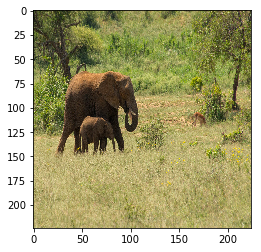

In [80]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE=(224,224)

# where is the image
img_path = "data/elephants.jpg"
#img_path = "data/elephant.jpg"
#img_path = "data/car.jpg"
#img_path = "data/fruits.jpg"
#img_path = "data/sunglasses.jpg"
#img_path = "data/sunglasses2.jpg"

# load image
img = image.load_img(img_path, target_size=IMG_SIZE)

# x is now a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# we add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# finally we preprocess the batch
# since the VGG16 was trained on such _preprocessed_ images
# (this does channel-wise color normalization)
x = preprocess_input(x)

# show the rescaled image
plt.imshow(img)
plt.show()

# What does the CNN see in the image?

In [81]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n01871265', 'tusker', 0.4292425), ('n02504458', 'African_elephant', 0.3744305), ('n02410509', 'bison', 0.09596181)]


In [82]:
output_neuron_nr = np.argmax(preds[0])
print("Predicted class corresponds to output neuron nr {}"
      .format(output_neuron_nr))

Predicted class corresponds to output neuron nr 101


# Compute Grad-CAM

In [83]:
# Get the output tensor for this class
output_tensor = model.output[:, output_neuron_nr]
print("output_tensor has type", type(output_tensor))

# Get last conv layer of VGG16
last_conv_layer = model.get_layer('block5_conv3')
print("last_conv_layer has type", type(last_conv_layer))

# Compute gradients of the selected output tensor regarding
# the output feature map of "block5_conv3" = last conv layer
grads = K.gradients(output_tensor, last_conv_layer.output)[0]
print("grads has type", type(grads))
print("grads has shape", grads.shape)
print("grads object: ", grads)

# Now compute the mean gradient for each feature map
# We compute the mean over several dimensions
# dimension 0: image nr in image batch
# dimension 1: image height
# dimension 2: image width
# Only the last dimension 
# The values here correspond to the {alpha}_k^c values in the
# original paper
mean_grads = K.mean(grads, axis=(0, 1, 2))
print(mean_grads)

# Now we need a way to access the values
# - pooled_grads
# and
# - last conv layer
# given an input image
# For this we can use K.function()
#
# For the purpose of K.function(), see
# https://stackoverflow.com/questions/48142181/whats-the-purpose-of-keras-backend-function
helper_func =\
    K.function([model.input],
               [mean_grads, last_conv_layer.output[0]])

# Now, get the actual values (NumPy arrays) from the tensors
# using  this helper function
mean_grads_value, conv_layer_output_value = helper_func([x])
print("shape of mean_grads_value is", mean_grads_value.shape)
print("shape of conv_layer_output_value is", conv_layer_output_value.shape)

# Now, combine (1) and (2):
# Multiply each feature map with its importance regarding
# the selected class (output neuron)
for i in range(512):
    conv_layer_output_value[:, :, i] *= mean_grads_value[i]

# Now we do not want to show the importance of each feature map
# for the classification decision,
# but we want to show the importance of each pixel for the
# classification decision.
# For this, compute the channel-wise mean
# (mean pooling dimension is the last dimension, i.e. -1)
heatmap = np.mean(conv_layer_output_value, axis=-1)

print("shape of heatmap is", heatmap.shape)

output_tensor has type <class 'tensorflow.python.framework.ops.Tensor'>
last_conv_layer has type <class 'keras.layers.convolutional.Conv2D'>
grads has type <class 'tensorflow.python.framework.ops.Tensor'>
grads has shape (?, 14, 14, 512)
grads object:  Tensor("gradients_23/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("Mean_23:0", shape=(512,), dtype=float32)
shape of mean_grads_value is (512,)
shape of conv_layer_output_value is (14, 14, 512)
shape of heatmap is (14, 14)


# Normalize the heat map values

min value of heatmap is  -3.6360852e-05
max value of heatmap is  9.709747e-06


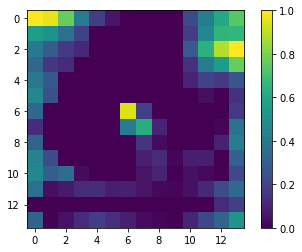

In [84]:
print("min value of heatmap is ", np.min(heatmap))
print("max value of heatmap is ", np.max(heatmap))

heatmap_relu_ed = np.maximum(heatmap, 0)

heatmap_normalized = heatmap_relu_ed / np.max(heatmap_relu_ed)

plt.imshow(heatmap_normalized)
plt.colorbar()
plt.show()


# Resize heatmap to image size

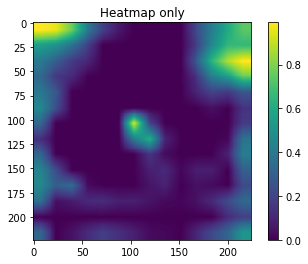

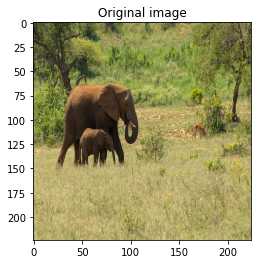

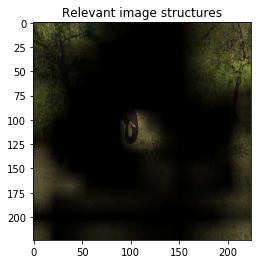

In [85]:
import cv2

# 1. show heatmap as large as original image

# resize the heatmap to the same size
# as the (VGG-16 resized) input image
heatmap_large = cv2.resize(heatmap_normalized, IMG_SIZE)

# show large heatmap
plt.title("Heatmap only")
plt.imshow(heatmap_large)
plt.colorbar()
plt.show()


# 2. show original image again

# load the image again
img = cv2.imread(img_path)
img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.title("Original image")
plt.imshow(img)
plt.show()


# 3. "highlight" image parts,
#    which were responsible for the
#    final classification

visu = img.copy()
visu[:,:,0] = visu[:,:,0] * heatmap_large
visu[:,:,1] = visu[:,:,1] * heatmap_large
visu[:,:,2] = visu[:,:,2] * heatmap_large

plt.title("Relevant image structures")
plt.imshow(visu)
plt.show()


# Batch processing

10 files in folder data
Filenames:  ['data/car.jpg', 'data/elephant.jpg', 'data/elephants.jpg', 'data/fruits.jpg', 'data/sunglasses.jpg', 'data/sunglasses2.jpg', 'data/sunglasses3.jpg', 'data/umbrella1.jpg', 'data/umbrella2.jpg', 'data/umbrella3.jpg']


File #0: data/car.jpg
Predicted: [('n04285008', 'sports_car', 0.7815369), ('n04037443', 'racer', 0.07829427), ('n02930766', 'cab', 0.053122815)]


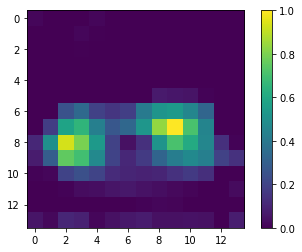

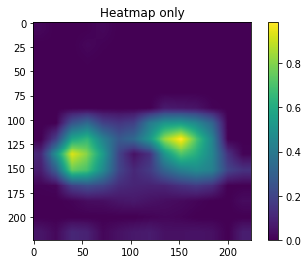

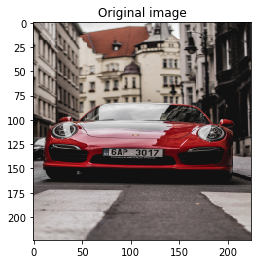

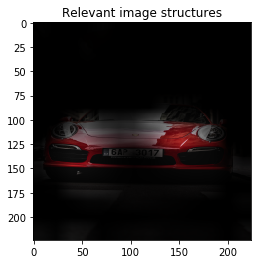



File #1: data/elephant.jpg
Predicted: [('n01871265', 'tusker', 0.55795145), ('n02504458', 'African_elephant', 0.3990946), ('n02504013', 'Indian_elephant', 0.039035276)]


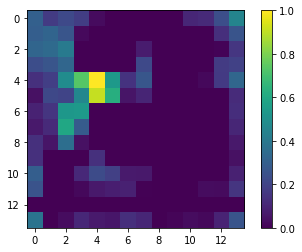

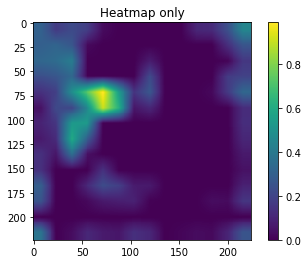

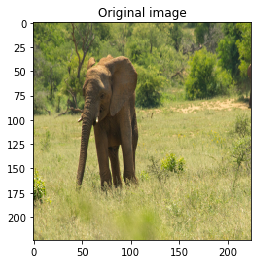

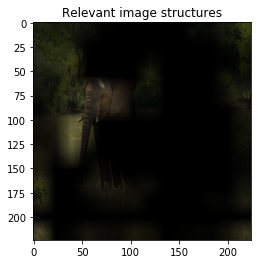



File #2: data/elephants.jpg
Predicted: [('n01871265', 'tusker', 0.4292425), ('n02504458', 'African_elephant', 0.3744305), ('n02410509', 'bison', 0.09596181)]


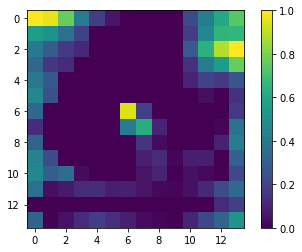

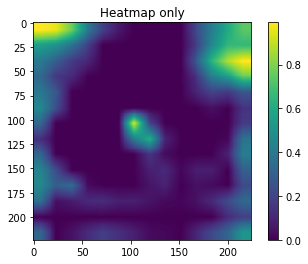

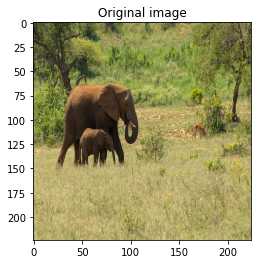

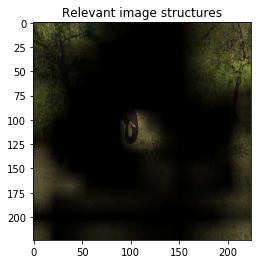



File #3: data/fruits.jpg
Predicted: [('n07749582', 'lemon', 0.35332945), ('n07753592', 'banana', 0.11959896), ('n07747607', 'orange', 0.085141964)]


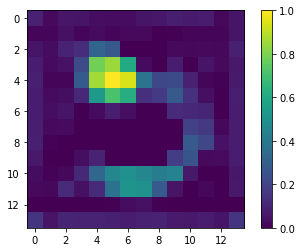

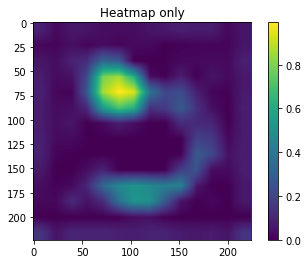

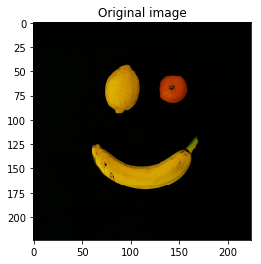

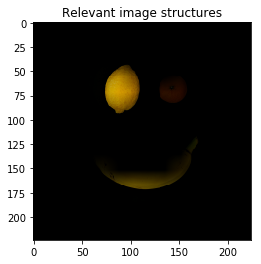



File #4: data/sunglasses.jpg
Predicted: [('n04355933', 'sunglass', 0.13886134), ('n01755581', 'diamondback', 0.11147165), ('n01729322', 'hognose_snake', 0.09075866)]


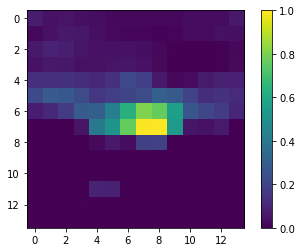

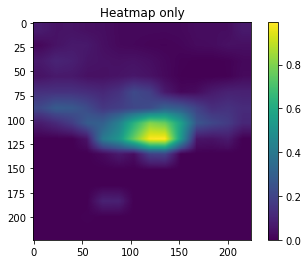

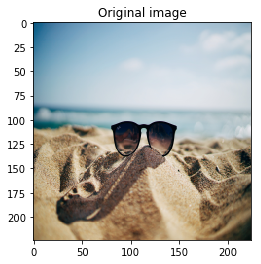

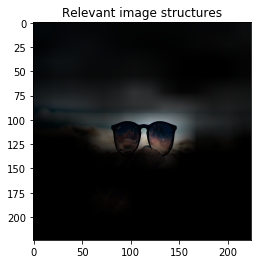



File #5: data/sunglasses2.jpg
Predicted: [('n04355933', 'sunglass', 0.23277217), ('n04356056', 'sunglasses', 0.17889063), ('n03404251', 'fur_coat', 0.089660056)]


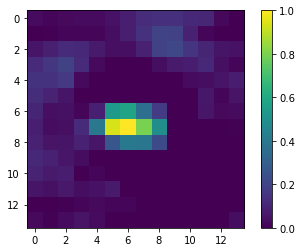

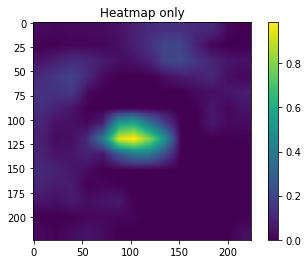

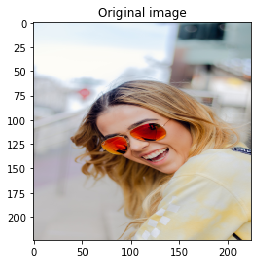

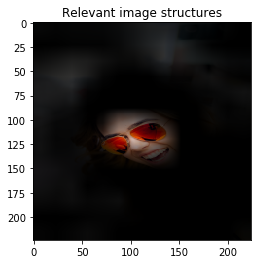



File #6: data/sunglasses3.jpg
Predicted: [('n02096051', 'Airedale', 0.2848321), ('n02100877', 'Irish_setter', 0.09719551), ('n02091635', 'otterhound', 0.08523598)]


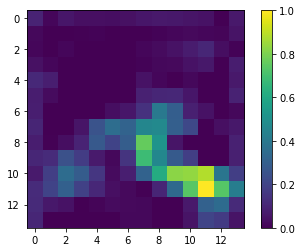

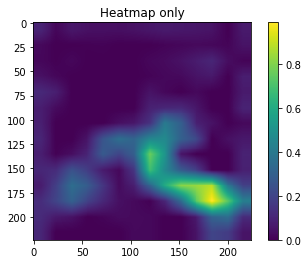

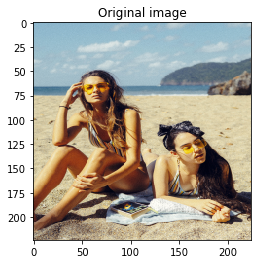

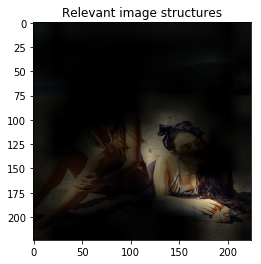



File #7: data/umbrella1.jpg
Predicted: [('n04507155', 'umbrella', 0.57841766), ('n03888257', 'parachute', 0.06342932), ('n09332890', 'lakeside', 0.058317136)]


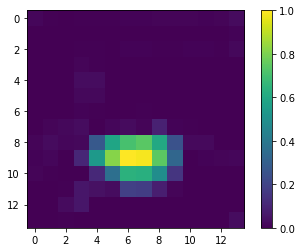

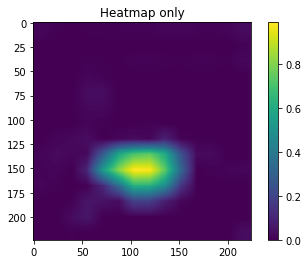

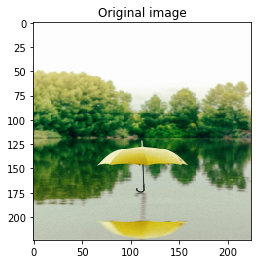

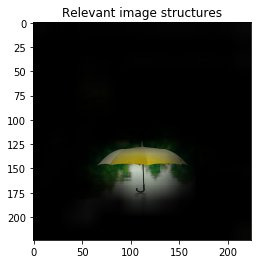



File #8: data/umbrella2.jpg
Predicted: [('n04507155', 'umbrella', 0.9443519), ('n04592741', 'wing', 0.016656859), ('n02692877', 'airship', 0.006692652)]


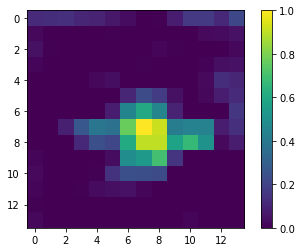

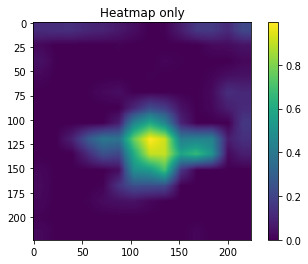

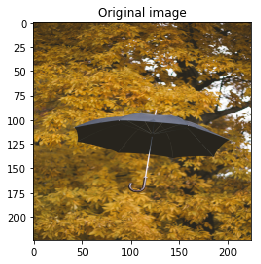

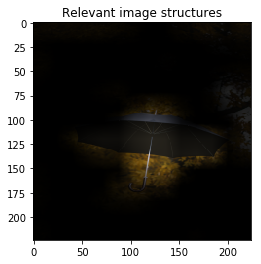



File #9: data/umbrella3.jpg
Predicted: [('n04507155', 'umbrella', 0.963839), ('n03598930', 'jigsaw_puzzle', 0.009945891), ('n03888257', 'parachute', 0.0068448433)]


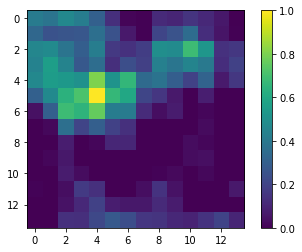

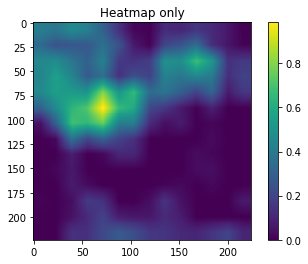

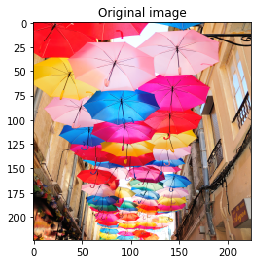

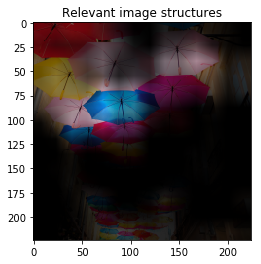

In [86]:
import os
from os import listdir
from os.path import isdir, isfile, join

def localize_relevant_image_structures(model, img_path):
    
    # load and preprocess img
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # predict
    preds = model.predict(x)
    print('Predicted:', decode_predictions(preds, top=3)[0])    
    output_neuron_nr = np.argmax(preds[0])
    
    # compute Grad-CAM
    output_tensor = model.output[:, output_neuron_nr]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output_tensor, last_conv_layer.output)[0]
    mean_grads = K.mean(grads, axis=(0, 1, 2))
    helper_func =\
        K.function([model.input],
                   [mean_grads, last_conv_layer.output[0]])
    mean_grads_value, conv_layer_output_value = helper_func([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= mean_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)

    # normalize heatmap and show it
    heatmap_relu_ed = np.maximum(heatmap, 0)
    heatmap_normalized = heatmap_relu_ed / np.max(heatmap_relu_ed)
    plt.imshow(heatmap_normalized)
    plt.colorbar()
    plt.show()

    # create and show large heatmap
    heatmap_large = cv2.resize(heatmap_normalized, IMG_SIZE)
    plt.title("Heatmap only")
    plt.imshow(heatmap_large)
    plt.colorbar()
    plt.show()

    # load the image again
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title("Original image")
    plt.imshow(img)
    plt.show()


    # "highlight" relevant image structures
    visu = img.copy()
    visu[:,:,0] = visu[:,:,0] * heatmap_large
    visu[:,:,1] = visu[:,:,1] * heatmap_large
    visu[:,:,2] = visu[:,:,2] * heatmap_large

    plt.title("Relevant image structures")
    plt.imshow(visu)
    plt.show()


folder_name = "data"
filenames = [folder_name + "/" + f
             for f in listdir(folder_name)
             if isfile(join(folder_name, f))]

print("{} files in folder {}".format(len(filenames),
                                        folder_name) )
print("Filenames: ", filenames)

for file_nr,filename in enumerate(filenames):
    
    print("\n\nFile #{}: {}".format(file_nr, filename))
    
    localize_relevant_image_structures(model, filename)